In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
import xgboost as xgb #BDT
import pickle

from utils.analysis import Optimization

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
babies = glob.glob("../analysis/studies/vbsvvhjets/output_ttH/Run2/*.root")
babies = [baby for baby in babies if "data" not in baby]
babies

['../analysis/studies/vbsvvhjets/output_ttH/Run2/TTbar.root',
 '../analysis/studies/vbsvvhjets/output_ttH/Run2/QCD.root',
 '../analysis/studies/vbsvvhjets/output_ttH/Run2/VBSVVH.root']

In [3]:
vbsvvh = Optimization(
    sig_root_files=babies[-1:],
    bkg_root_files=babies[:-1],
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", 
        "pu_sf",
        "prefire_sf"
    ]
)

Loading bkg babies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.79s/it]


In [4]:
vbsvvh.sig_count(
    selection=(
        "M_jj > 500 and abs(deta_jj) > 3"
        + "and hbbfatjet_score > 0.9"
        + "and ld_vqqfatjet_score > 0.9 and tr_vqqfatjet_score > 0.9"
        + "and ST > 1300"
        + "and hbbfatjet_msoftdrop < 150"
        + "and ld_vqqfatjet_msoftdrop < 120 and tr_vqqfatjet_msoftdrop < 120"
    )
)

3.2448080218232445

In [5]:
vbsvvh.bkg_count(
    selection=(
        "M_jj > 500 and abs(deta_jj) > 3"
        + "and hbbfatjet_score > 0.9"
        + "and ld_vqqfatjet_score > 0.9 and tr_vqqfatjet_score > 0.9"
        + "and ST > 1300"
        + "and hbbfatjet_msoftdrop < 150"
        + "and ld_vqqfatjet_msoftdrop < 120 and tr_vqqfatjet_msoftdrop < 120"
    )
)

1.4065299727892357

In [6]:
vbsvvh.make_selection(
    "ST > 1300"
    + "and hbbfatjet_score > 0.5"
    + "and ld_vqqfatjet_score > 0.5 and tr_vqqfatjet_score > 0.5"
    + "and ld_vqqfatjet_msoftdrop < 120 and tr_vqqfatjet_msoftdrop < 120"
    + "and hbbfatjet_msoftdrop < 150"
)
vbsvvh.set_split_column(ratio=0.6, name="split")

In [7]:
vbsvvh.df["abs_deta_jj"] = np.abs(vbsvvh.df.deta_jj)
vbsvvh.df.columns

Index(['HT', 'n_jets', 'n_loose_b_jets', 'n_medium_b_jets', 'n_tight_b_jets',
       'btag_sf', 'btag_sf_up', 'btag_sf_dn', 'n_fatjets', 'ld_vbsjet_pt',
       'ld_vbsjet_eta', 'ld_vbsjet_phi', 'tr_vbsjet_pt', 'tr_vbsjet_eta',
       'tr_vbsjet_phi', 'M_jj', 'deta_jj', 'abs_deta_jj', 'dR_jj', 'xsec_sf',
       'pu_sf', 'pu_sf_up', 'pu_sf_dn', 'prefire_sf', 'prefire_sf_up',
       'prefire_sf_dn', 'trig_sf', 'trig_sf_up', 'trig_sf_dn', 'event', 'MET',
       'MET_up', 'MET_dn', 'lhe_muF0p5_muR0p5', 'lhe_muF1p0_muR0p5',
       'lhe_muF2p0_muR0p5', 'lhe_muF0p5_muR1p0', 'lhe_muF1p0_muR1p0',
       'lhe_muF2p0_muR1p0', 'lhe_muF0p5_muR2p0', 'lhe_muF1p0_muR2p0',
       'lhe_muF2p0_muR2p0', 'ps_isr2p0_fsr1p0', 'ps_isr1p0_fsr2p0',
       'ps_isr0p5_fsr1p0', 'ps_isr1p0_fsr0p5', 'ld_vqqfatjet_score',
       'ld_vqqfatjet_pt', 'ld_vqqfatjet_eta', 'ld_vqqfatjet_phi',
       'ld_vqqfatjet_mass', 'ld_vqqfatjet_msoftdrop', 'tr_vqqfatjet_score',
       'tr_vqqfatjet_pt', 'tr_vqqfatjet_eta', 'tr_vqqfatj

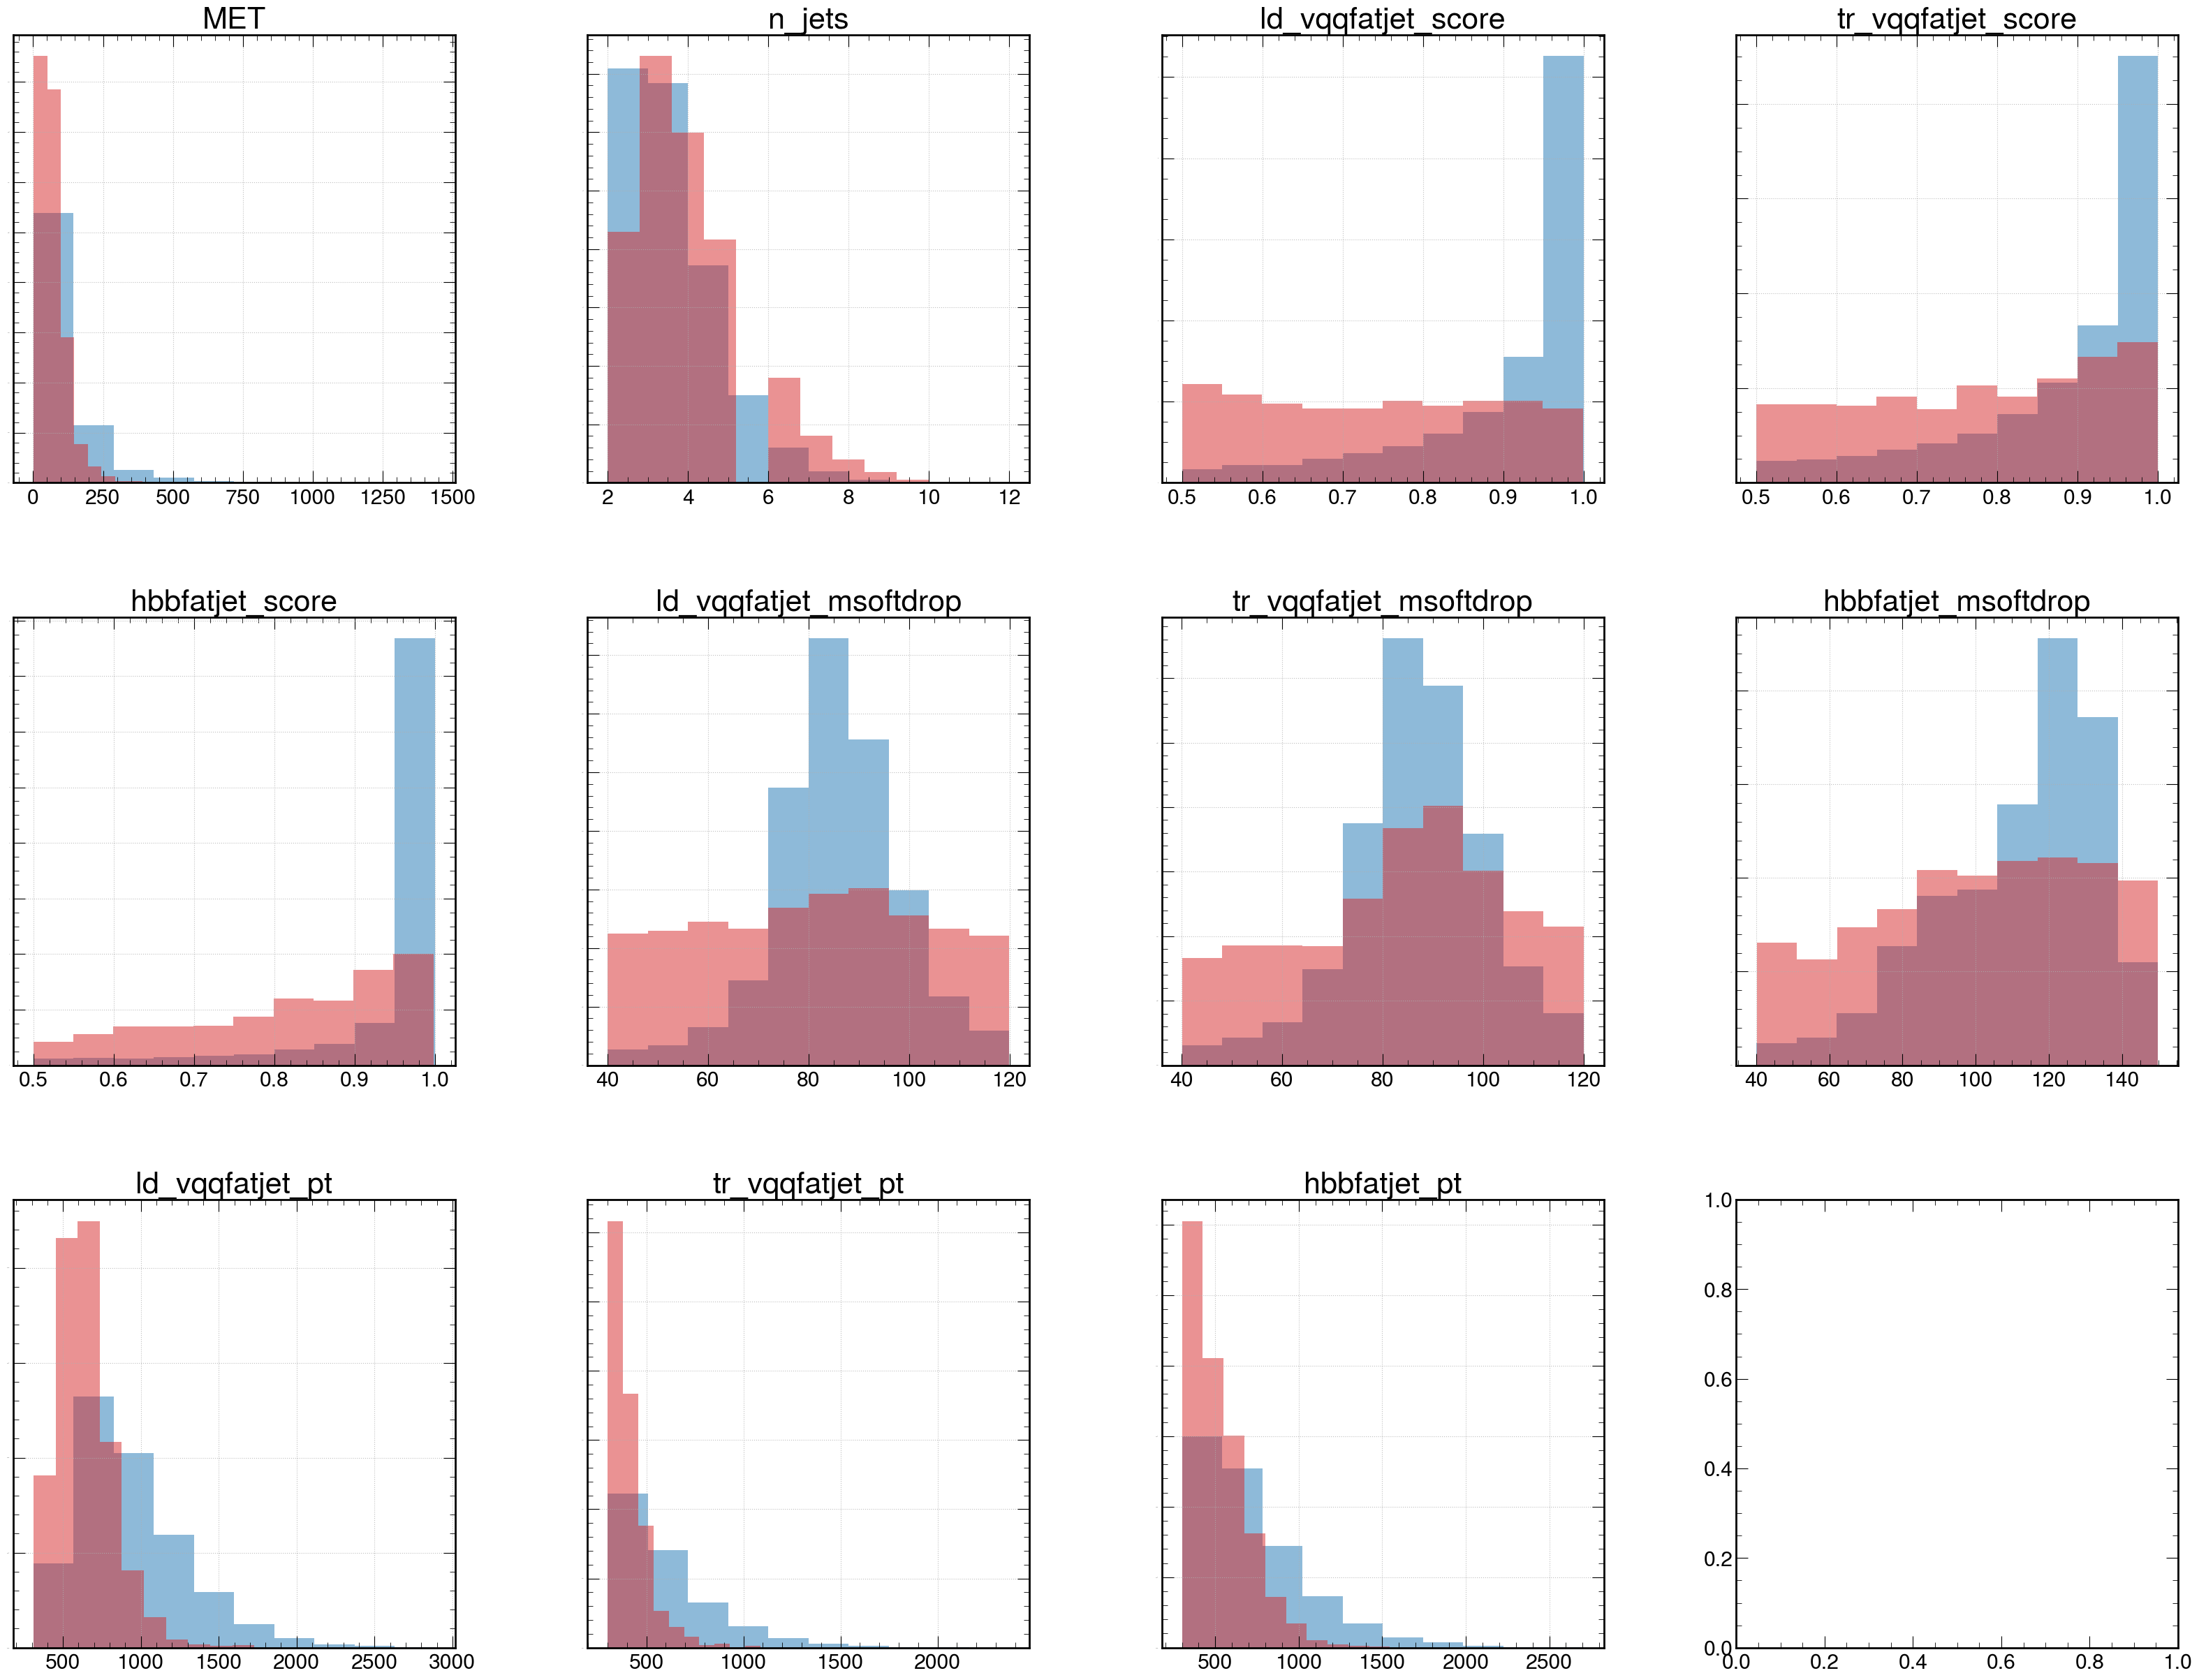

In [19]:
# # Select features
features = [
    "MET",
    "n_jets",
    "ld_vqqfatjet_score",
    "tr_vqqfatjet_score",
    "hbbfatjet_score",
    "ld_vqqfatjet_msoftdrop",
    "tr_vqqfatjet_msoftdrop",
    "hbbfatjet_msoftdrop",
#     "ST",
    "ld_vqqfatjet_pt",
    "tr_vqqfatjet_pt",
    "hbbfatjet_pt",
]

# Plot feature shapes
fig, axes = plt.subplots(3,4,figsize=(40,30))

sig_df = vbsvvh.sig_df()
bkg_df = vbsvvh.bkg_df()

ax = sig_df[features].hist(
    ax=axes.flatten()[:len(features)],
    alpha=0.5, color="C0", ylabelsize=0, 
    density=True
)
ax = bkg_df[features].hist(
    ax=axes.flatten()[:len(features)], 
    alpha=0.5, color="C3", ylabelsize=0, 
    density=True
)

In [9]:
train_df = vbsvvh.df[vbsvvh.df.split].sample(frac=1.)
test_df = vbsvvh.df[~vbsvvh.df.split].sample(frac=1.)

# BDT input
dtest = xgb.DMatrix(
    test_df[features], 
    label=test_df.is_signal,
    weight=np.abs(test_df.split_weight)
)
dtrain = xgb.DMatrix(
    train_df[features], 
    label=train_df.is_signal, 
    weight=np.abs(train_df.split_weight)
)
evallist = [(dtrain, "train"), (dtest, "eval")]

# BDT parameters setup
params = {}
params["objective"] = "binary:logistic"

# BDT knobs (hyper-parameters)
num_round = 500                  # Number of training rounds
params["eta"] = 0.1              # Step size shrinkage (alias: learning_rate)
params["max_depth"] = 3          # Max. depth of tree: larger = more complex = more prone to overfitting
params["verbosity"] = 1          # 0 (silent), 1 (warning), 2 (info), 3 (debug)
params["nthread"] = 8            # Number of parallel threads
params["eval_metric"] = "auc"    # Evaluation metrics for validation data. 'auc' = Area Under the Curve
params["subsample"] = 0.6        # Subsample ratio of the training instances
params["alpha"] = 8.0            # L1 regularization term on weights: Larger = more conservative
params["gamma"] = 2.0            # Min. loss rediction to make leaf (alias: min_split_loss)
params["lambda"] = 1.0           # L2 regularization term on weights: Larger = more conservative
params["min_child_weight"] = 1.0 # Minimum sum of instance weight (hessian) needed in a child
params["colsample_bytree"] = 1.0 # The subsample ratio of columns when constructing each tree
# params["base_score"] = 0.1       # The initial prediction score of all instances, global bias

# Get pos/neg weights
sumw_pos = np.abs(dtrain.get_weight()[dtrain.get_label() == 1]).sum()
sumw_neg = np.abs(dtrain.get_weight()[dtrain.get_label() == 0]).sum()
# Control the balance of positive and negative weights, useful for unbalanced classes
# A typical value to consider: sum(negative instances) / sum(positive instances)
params["scale_pos_weight"] = sumw_neg/sumw_pos

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [10]:
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval=True)

[0]	train-auc:0.92441	eval-auc:0.89946
[1]	train-auc:0.94036	eval-auc:0.91942
[2]	train-auc:0.94892	eval-auc:0.92897
[3]	train-auc:0.94968	eval-auc:0.93105
[4]	train-auc:0.95425	eval-auc:0.94210
[5]	train-auc:0.95884	eval-auc:0.94296
[6]	train-auc:0.95930	eval-auc:0.94332
[7]	train-auc:0.96371	eval-auc:0.94990
[8]	train-auc:0.96619	eval-auc:0.95400
[9]	train-auc:0.96746	eval-auc:0.95599
[10]	train-auc:0.96751	eval-auc:0.95614
[11]	train-auc:0.96892	eval-auc:0.95810
[12]	train-auc:0.96964	eval-auc:0.95877
[13]	train-auc:0.97086	eval-auc:0.96074
[14]	train-auc:0.97108	eval-auc:0.96159
[15]	train-auc:0.97205	eval-auc:0.96287
[16]	train-auc:0.97218	eval-auc:0.96272
[17]	train-auc:0.97444	eval-auc:0.96514
[18]	train-auc:0.97489	eval-auc:0.96592
[19]	train-auc:0.97595	eval-auc:0.96690
[20]	train-auc:0.97694	eval-auc:0.96784
[21]	train-auc:0.97732	eval-auc:0.96843
[22]	train-auc:0.97764	eval-auc:0.96886
[23]	train-auc:0.97762	eval-auc:0.96883
[24]	train-auc:0.97778	eval-auc:0.96915
[25]	train

In [11]:
# Get predictions
preds_train = bst.predict(xgb.DMatrix(train_df[features]))
preds_test = bst.predict(xgb.DMatrix(test_df[features]))

y_train = train_df.is_signal
y_test = test_df.is_signal

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


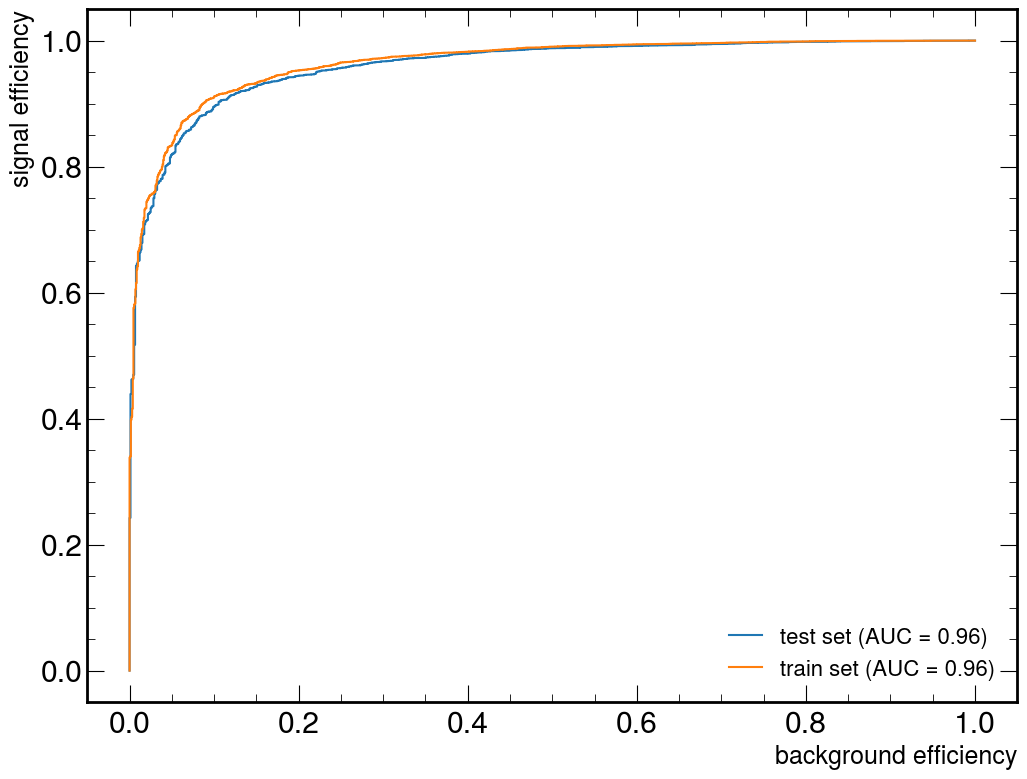

In [12]:
fig, axes = plt.subplots(figsize=(12,9))

# Test ROC Curve
fpr, tpr, thresh = roc_curve(test_df.is_signal, preds_test)
plt.plot(fpr, tpr, label="test set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));

# Train ROC Curve
fpr, tpr, thresh = roc_curve(train_df.is_signal, preds_train)
plt.plot(fpr, tpr, label="train set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));

plt.xlabel("background efficiency", size=18);
plt.ylabel("signal efficiency", size=18);
plt.legend(fontsize=16);

In [13]:
vbsvvh.df["bdt"] = bst.predict(xgb.DMatrix(vbsvvh.df[features]))

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<AxesSubplot:xlabel='BDT Score', ylabel='Events'>

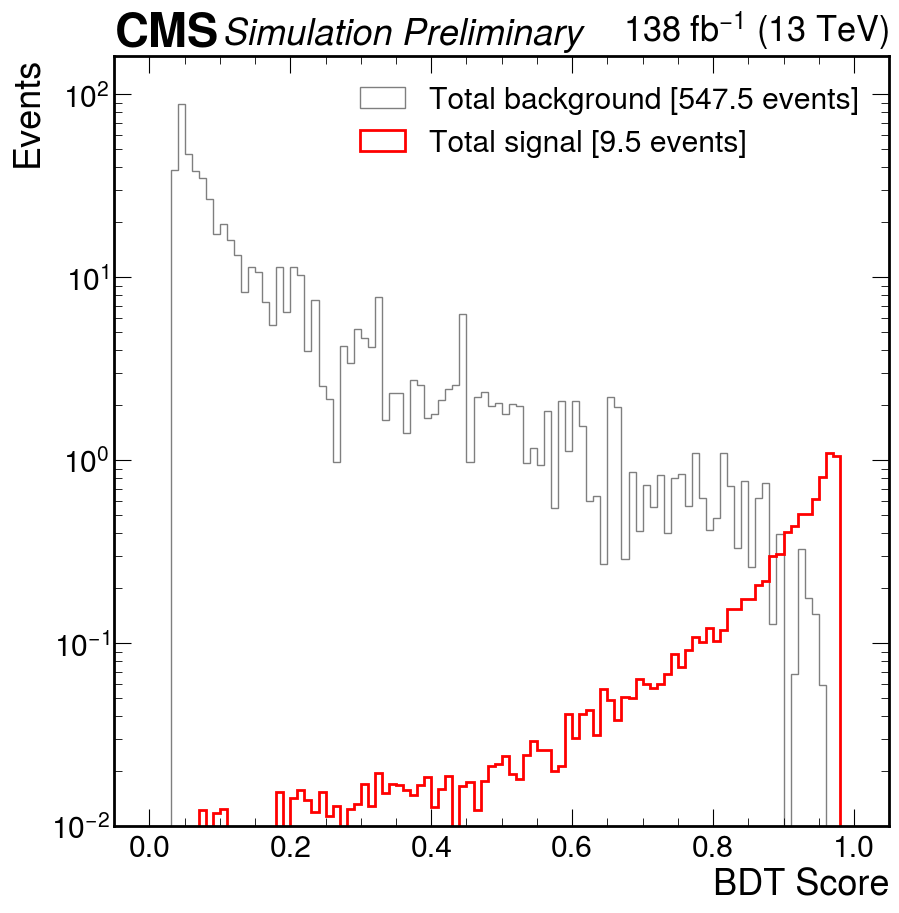

In [14]:
vbsvvh.plot_sig_vs_bkg("bdt", np.linspace(0, 1, 101), x_label="BDT Score", logy=True)

In [21]:
vbsvvh.fom_scan("bdt", [0.8, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9], base_selection="M_jj > 500 and abs(deta_jj) > 3")

sel,sig,bkg,fom
M_jj > 500 and abs(deta_jj) > 3,8.641890516350356,168.86181010332805,0.665032760437498
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.8,6.743549226242909,1.9589969264444027,4.818053906743088
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.85,6.10428430307336,0.7211993205174458,7.1879839377123
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.86,5.9459229417197275,0.6447254997604537,7.405115773323506
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.87,5.758539875712154,0.3619154591633149,9.572134918802856
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.88,5.556518582909484,0.3619154591633149,9.236324954312684
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.89,5.2834993761308375,0.2940807906961146,9.74290194626635
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.9,5.009616977933767,0.2255409739048274,10.548526455541143


In [16]:
for key, val in params.items():
    print(f"{key},{val}")

objective,binary:logistic
eta,0.1
max_depth,3
verbosity,1
nthread,8
eval_metric,auc
subsample,0.6
alpha,8.0
gamma,2.0
lambda,1.0
min_child_weight,1.0
colsample_bytree,1.0
scale_pos_weight,57.97358703613281


In [17]:
# Write features list
with open("../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt_features.txt", "w") as txt_file:
    txt_file.write("\n".join(features))

# Write BDT model
pickle.dump(bst, open("../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt.pkl", "wb"))
bst.save_model("../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt.model")
bst.dump_model(
    "../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt.json", 
    "../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt_features.txt"
)